# 🥛 Milk Quality Grading using Explainable Machine Learning

This project aims to classify milk quality into **Low**, **Medium**, and **High** grades
using machine learning models based on physicochemical and sensory attributes.

The project follows a **baseline-to-advanced modeling approach** and incorporates
**explainable AI (SHAP)** to ensure transparency and interpretability of predictions,
which is critical in food safety applications.


## 1. Import Required Libraries

This section imports all necessary Python libraries for data handling, visualization,
machine learning, class imbalance handling, and explainability.


In [99]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & modeling
from pathlib import Path
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

# Models (Baseline to Advanced)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Imbalance handling
from imblearn.over_sampling import SMOTE

import joblib
import shap

## 2. Dataset Loading

The dataset contains physicochemical and sensory features of milk samples
along with a quality grade label.


In [100]:
# For reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [101]:
df = pd.read_csv("milk_data.csv")
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (1059, 8)


,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade
0,6.6,35,1,0,1,0,254,high
1,6.6,36,0,1,0,1,253,high
2,8.5,70,1,1,1,1,246,low
3,9.5,34,1,1,0,1,255,low
4,6.6,37,0,0,0,0,255,medium


## 3. Initial Data Inspection

Basic checks were performed to understand the dataset structure,
data types, and presence of missing values.


In [102]:
# Basic info
print(df.info())
print(df.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1059 entries, 0 to 1058
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pH          1059 non-null   float64
 1   Temprature  1059 non-null   int64  
 2   Taste       1059 non-null   int64  
 3   Odor        1059 non-null   int64  
 4   Fat         1059 non-null   int64  
 5   Turbidity   1059 non-null   int64  
 6   Colour      1059 non-null   int64  
 7   Grade       1059 non-null   object 
dtypes: float64(1), int64(6), object(1)
memory usage: 66.3+ KB
None
                 pH   Temprature        Taste         Odor         Fat   \
count   1059.000000  1059.000000  1059.000000  1059.000000  1059.000000   
unique          NaN          NaN          NaN          NaN          NaN   
top             NaN          NaN          NaN          NaN          NaN   
freq            NaN          NaN          NaN          NaN          NaN   
mean       6.630123    44.226629     0.54

In [103]:
# Value counts for target
if 'Grade' in df.columns:
    print("\nTarget distribution:\n", df['Grade'].value_counts())


Target distribution:
 Grade
low       429
medium    374
high      256
Name: count, dtype: int64


## 4. Exploratory Data Analysis (EDA)

Exploratory Data Analysis (EDA) was performed to understand the underlying
structure of the data, including feature distributions, correlations,
and potential relationships between variables.

EDA helps in:
- Identifying skewness and outliers
- Understanding feature ranges
- Detecting multicollinearity
- Supporting preprocessing and model selection decisions


Numeric columns: ['pH', 'Temprature', 'Taste', 'Odor', 'Fat ', 'Turbidity', 'Colour']


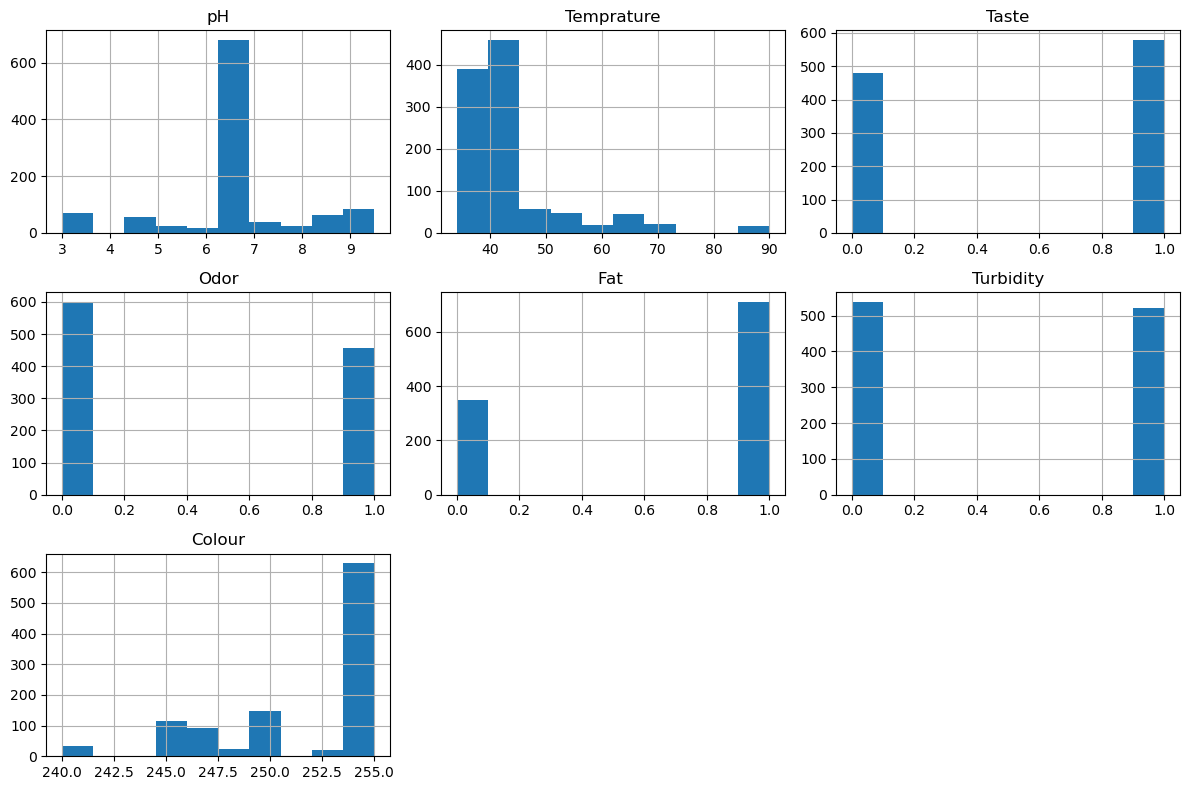

In [104]:
# Visual: Histograms for numeric features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:", numeric_cols)
df[numeric_cols].hist(figsize=(12,8))
plt.tight_layout()
plt.show()

### 5. Distribution of Numerical Features

Histograms visualize the distribution of numerical variables and help
identify skewness, outliers, and scale differences among features.


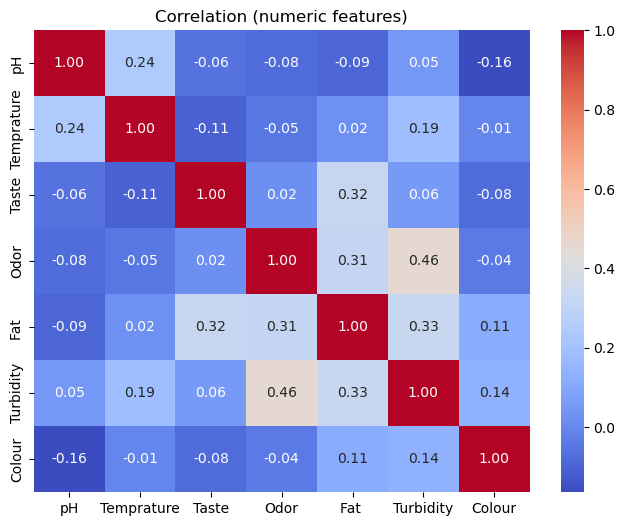

In [105]:
# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation (numeric features)")
plt.show()

## 6. Target Variable Distribution

The distribution of milk quality grades was visualized to check for
class imbalance.


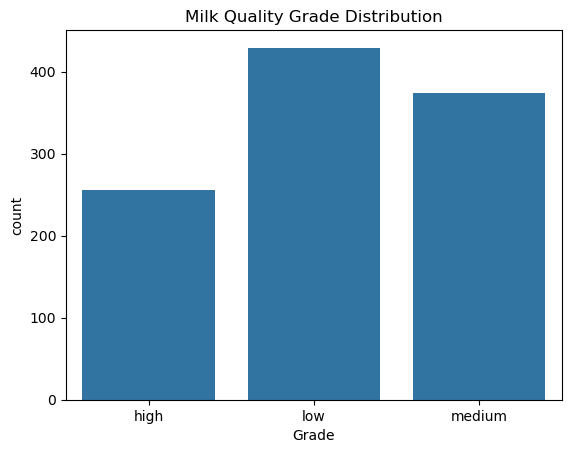

In [106]:
sns.countplot(x='Grade', data=df)
plt.title("Milk Quality Grade Distribution")
plt.show()

## 7. Feature–Target Separation

Input features and target variable were separated for model development.


In [107]:
X = df.drop('Grade', axis=1)
y = df['Grade']

## 8. Target Encoding

The categorical target variable was encoded into numerical form
to make it suitable for machine learning models.


In [108]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

## 9. Feature Engineering

Domain-driven features were engineered to capture spoilage behavior
and combined sensory quality effects.


In [109]:
X['pH_Temperature_interaction'] = X['pH'] * X['Temprature']
X['sensory_score'] = X[['Taste', 'Odor', 'Fat ', 'Turbidity']].sum(axis=1)

## 10. Train–Test Split

The dataset was split into training and testing sets using stratified sampling
to preserve class distribution.


In [110]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=RANDOM_STATE, stratify=y_encoded
)

## 11. Data Preprocessing

Numerical features were scaled, while binary features were passed directly
using a ColumnTransformer.


In [111]:
numeric_features = ['pH', 'Temprature', 'Colour', 
                    'pH_Temperature_interaction', 'sensory_score']

binary_features = ['Taste', 'Odor', 'Fat ', 'Turbidity']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('bin', 'passthrough', binary_features)
])

## 12. Baseline Model: Logistic Regression

Logistic Regression was used as a baseline model due to its simplicity
and interpretability.


In [112]:
baseline_pipeline = ImbPipeline([
    ('preprocess', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])

baseline_pipeline.fit(X_train, y_train)
baseline_pred = baseline_pipeline.predict(X_test)

print("Baseline Accuracy:", accuracy_score(y_test, baseline_pred))


Baseline Accuracy: 0.8254716981132075


## 13. Intermediate Models

More complex models were evaluated to capture non-linear relationships
among milk quality parameters.


In [113]:
svm_pipeline = ImbPipeline([
    ('preprocess', preprocessor),
    ('model', SVC(kernel='rbf'))
])

svm_pipeline.fit(X_train, y_train)
svm_pred = svm_pipeline.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, svm_pred))

SVM Accuracy: 0.9433962264150944


In [114]:
rf_pipeline = ImbPipeline([
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=200,
        random_state=42
    ))
])

rf_pipeline.fit(X_train, y_train)
rf_pred = rf_pipeline.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))

Random Forest Accuracy: 0.9952830188679245


In [115]:
rf_smote_pipeline = ImbPipeline([
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier(n_estimators=300, random_state=42))
])

rf_smote_pipeline.fit(X_train, y_train)
rf_smote_pred = rf_smote_pipeline.predict(X_test)

print("RF + SMOTE Accuracy:", accuracy_score(y_test, rf_smote_pred))

RF + SMOTE Accuracy: 0.9952830188679245


## 14. Handling Class Imbalance and Final Model

SMOTE was applied within the pipeline to handle class imbalance,
and XGBoost was selected as the final model.


In [116]:
xgb_pipeline = ImbPipeline([
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', XGBClassifier(
        n_estimators=300,
        max_depth=5,
        learning_rate=0.1,
        eval_metric='mlogloss',
        random_state=42
    ))
])

xgb_pipeline.fit(X_train, y_train)
xgb_pred = xgb_pipeline.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, xgb_pred))

XGBoost Accuracy: 1.0


In [117]:
xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['pH', 'Temprature', 'Colour',
                                                   'pH_Temperature_interaction',
                                                   'sensory_score']),
                                                 ('bin', 'passthrough',
                                                  ['Taste', 'Odor', 'Fat ',
                                                   'Turbidity'])])),
                ('smote', SMOTE(random_state=42)),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsam...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, ...))])

## 15. Model Evaluation

The final model was evaluated using accuracy, classification report,
and confusion matrix.


In [118]:
print("\nClassification Report:\n",
      classification_report(y_test, xgb_pred, target_names=label_encoder.classes_))


Classification Report:
               precision    recall  f1-score   support

        high       1.00      1.00      1.00        51
         low       1.00      1.00      1.00        86
      medium       1.00      1.00      1.00        75

    accuracy                           1.00       212
   macro avg       1.00      1.00      1.00       212
weighted avg       1.00      1.00      1.00       212



In [119]:
models = {
    "Logistic Regression": baseline_pipeline,
    "SVM": svm_pipeline,
    "Random Forest": rf_pipeline,
    "RF + SMOTE": rf_smote_pipeline,
    "XGBoost + SMOTE": xgb_pipeline
}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"{name} CV Accuracy: {scores.mean():.3f}")

Logistic Regression CV Accuracy: 0.843
SVM CV Accuracy: 0.942
Random Forest CV Accuracy: 0.996
RF + SMOTE CV Accuracy: 0.998
XGBoost + SMOTE CV Accuracy: 0.995


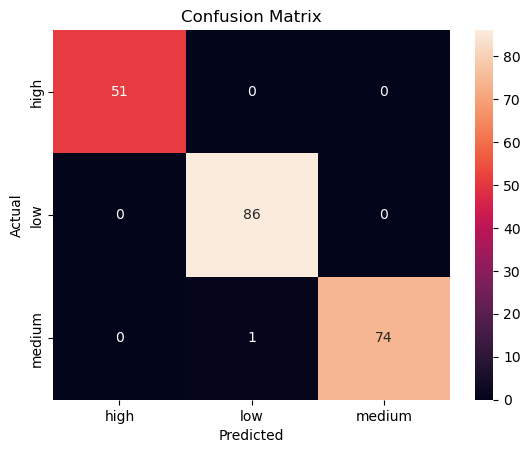

In [120]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [121]:
cv_scores = cross_val_score(xgb_pipeline, X_train, y_train, cv=5)
print("CV Mean Accuracy:", cv_scores.mean())

CV Mean Accuracy: 0.9952801949182039


In [122]:
joblib.dump(pipeline, "milk_quality_pipeline.pkl")

['milk_quality_pipeline.pkl']

In [123]:
joblib.dump(label_encoder, "label_encoder.pkl")

['label_encoder.pkl']

## 16. Model Explainability using SHAP

SHAP was used to explain both global and local model predictions,
ensuring transparency in decision-making.


In [124]:
# Extract trained XGBoost model
xgb_model = xgb_pipeline.named_steps['model']

# Transform training & test data (without SMOTE for explanation)
X_train_processed = xgb_pipeline.named_steps['preprocess'].transform(X_train)
X_test_processed = xgb_pipeline.named_steps['preprocess'].transform(X_test)

In [125]:
explainer = shap.Explainer(xgb_model, X_train_processed)
shap_values = explainer(X_test_processed)

 99%|===================| 627/636 [00:26<00:00]        

C:\Users\Victus\AppData\Local\Temp\ipykernel_147640\1618304092.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_processed)


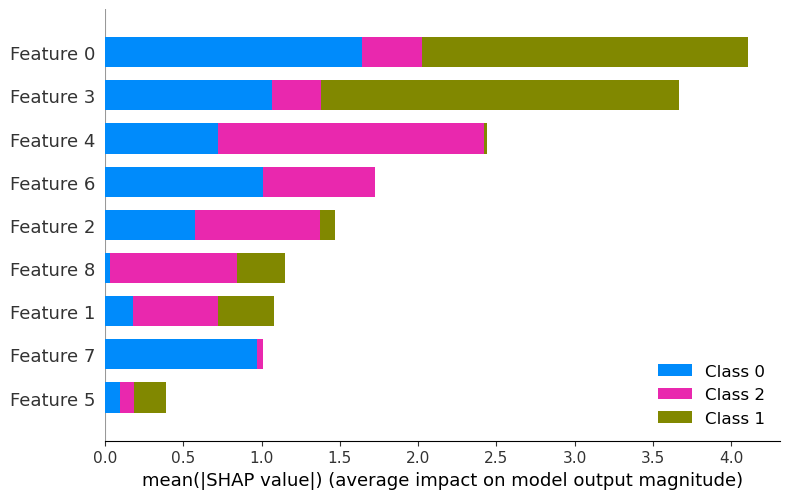

In [126]:
shap.summary_plot(shap_values, X_test_processed)

C:\Users\Victus\AppData\Local\Temp\ipykernel_147640\669430756.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[..., 0], X_test_processed, show=False)


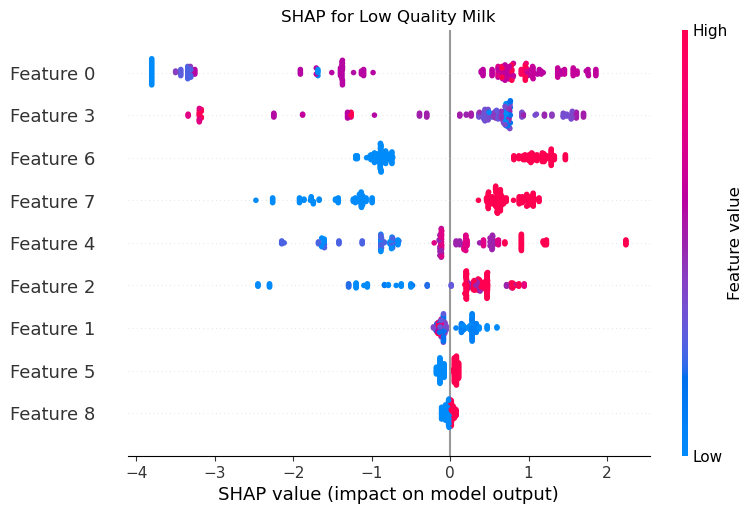

C:\Users\Victus\AppData\Local\Temp\ipykernel_147640\669430756.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[..., 2], X_test_processed, show=False)


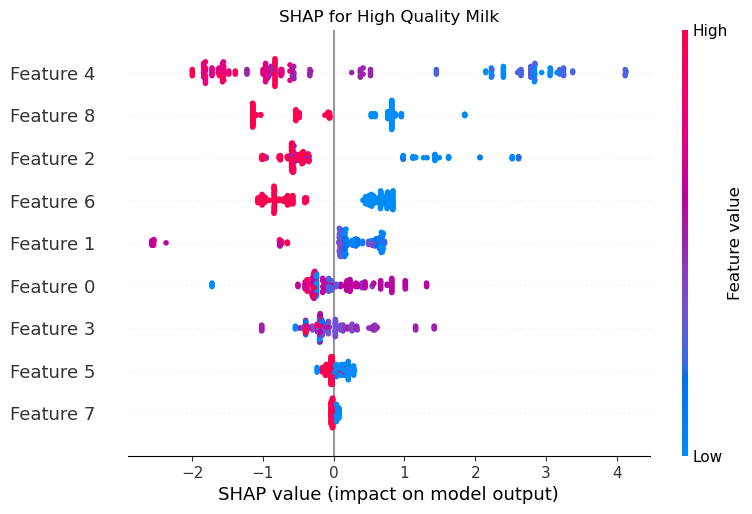

In [127]:
# For multiclass classification
shap.summary_plot(shap_values[..., 0], X_test_processed, show=False)
plt.title("SHAP for Low Quality Milk")
plt.show()

shap.summary_plot(shap_values[..., 2], X_test_processed, show=False)
plt.title("SHAP for High Quality Milk")
plt.show()

## 17. Local Explanation for a Single Sample


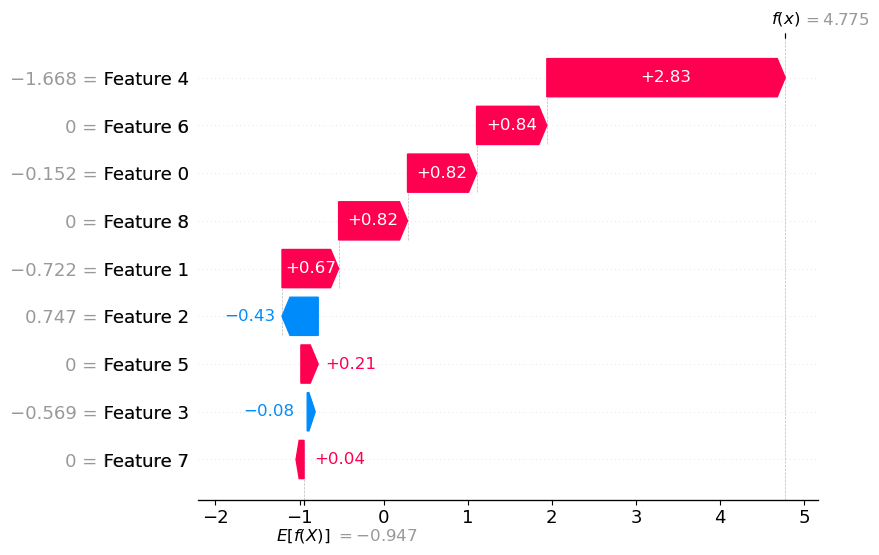

In [128]:
sample_index = 0

# get predicted class for this sample
predicted_class = xgb_pred[sample_index]

# SHAP waterfall for predicted class
shap.plots.waterfall(
    shap_values[sample_index, :, predicted_class]
)